# 1. Setup

### Imports

In [1]:
# reload new modules automatically
%load_ext autoreload
%autoreload 2

In [2]:
try:
    from egrabber import *
except:
    print('Egrabber not found, continuing without it.')
import numpy as np
import time
import cv2
import ctypes
# from tqdm import tqdm
import winsound
import warnings
from datetime import datetime
import math
from scipy.signal import butter, filtfilt,resample
from scipy.io.wavfile import write

# Add parent directory to path for local imports
import sys
from pathlib import Path
if str(Path.cwd().parent) not in sys.path:
    sys.path.insert(0, str(Path.cwd().parent))

# local imports
from utils.recover_core_lib import *

SWP_NOMOVE = 0x0002
SWP_NOSIZE = 0x0001
HWND_TOPMOST = -1

import traceback

import matplotlib.pyplot as plt

from threading import Thread
import os

signal_crop = None
if 'run_opt' not in locals():
    run_opt = {}
    
if 'run_opt_recovery' not in locals():
    run_opt_recovery = {}

# enable interactive matplotlib plots
%matplotlib inline

FONT = cv2.FONT_HERSHEY_SIMPLEX

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

c:\Users\ethantu\good-vibrations\.venv\Lib\site-packages\cupy\_environment.py:215: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


### Laser Camera Parameters

In [3]:
# setup laser camera parameters
N_ROI_ROWS = 10 # rows
N_ROI_COLUMNS = 10 # columns
ROI_ROW_HEIGHT = 30 # row height
ROI_COLUMN_WIDTH = 70 # column width

# calibrate on a smaller ROI with lower FPS
CALIBRATION_FPS = 500
CALIBRATION_EXPOSURE = 30
CALIBRATION_GAIN = 3

FPS = 2_500
EXPOSURE = 150
GAIN = 1

BUFFER_PART_COUNT = 3_000 # makes it faster to capture/send frames

### Box Camera Parameters

In [4]:
EXPOSURE_MS = 30        # Exposure time in milliseconds
FRAME_RATE = 30          # Target frame rate (FPS)
PIXEL_CLOCK = 86         # Pixel clock speed
CAMERA_GAIN = 40          # Camera gain (0-100) higher gain = brighter image
RESIZE_FACTOR = 0.75     # Preview resize factor for display
GAMMA = 1.0              # Gamma correction for preview

### Vibration Recording Parameters

In [ ]:
AUDIO_FILE = r'..\data\audio_samples\chirp_50_1000_5.0sec.wav'
N_CAPTURE_SECONDS   = 5.1  # Duration of capture in seconds

### Other Parameters

In [109]:
# BASE_DIR = '../data/experiment_02/' # needs to end with /
BASE_DIR = r'Z:\DATA\Eitan\experiment_02' # needs to end with /
os.makedirs(BASE_DIR, exist_ok=True)

In [121]:
PREVIEW_OVERHEAD_BOX_IMAGE = True  # Whether to preview overhead box image during recording
PREVIEW_VIBRATION_VIDEO = True # Whether to preview vibration video during recording

In [8]:
RESET_ROIS = True  # Whether to reset ROIs or use previous ones

# 2. Setup Laser Camera

In [9]:
class MikrotronCamera(object):

    def __init__(self, info_field=False, ):
        self.gentl   = EGenTL()
        self.grabber = EGrabber(self.gentl)
        self.grabber.remote.set("CxpLinkConfiguration", "CXP12_X4")
        self.grabber.stream.set('BufferPartCount', 1)
        self.update_size()
        self.grabber.realloc_buffers(20)
        #self.grabber.start()

        self.info_field = info_field
        if self.info_field:
            self.grabber.remote.set("InfoFieldTimeStampEnable", True)
            self.grabber.remote.set("InfoFieldFrameCounterEnable", True)
            self.grabber.remote.set("InfoFieldRoiEnable", True)
            
    def set_buffer_part_count(self, buffer_count):
        self.grabber.stream.set('BufferPartCount', buffer_count)
        self.grabber.realloc_buffers(20)
    
    def get_exposure(self):
        return self.grabber.remote.get("ExposureTime")
        
    def set_exposure(self, exposure_value):
        self.grabber.remote.set("ExposureTime", exposure_value)

    def get_frame_rate(self):
        return self.grabber.remote.get("AcquisitionFrameRate")
    
    def set_frame_rate(self, frame_rate):
        self.grabber.remote.set("AcquisitionFrameRate", frame_rate)
    
    def get_max_frame_rate(self):
        return self.grabber.remote.get("AcquisitionFrameRateMax")

    def get_acquisition_mode(self):
        return self.grabber.remote.get("AcquisitionMode")
    
    def set_gain(self, gain_value):
        self.grabber.remote.set("Gain", gain_value)
    
    def start_acquisition(self):
        self.grabber.remote.set("AcquisitionMode", "Continuous")
        self.grabber.remote.execute("AcquisitionStart")
        while not self.grabber.remote.done("AcquisitionStart"):
            pass
    
    def stop_acquisition(self):
        self.grabber.remote.execute("AcquisitionStop")
        while not self.grabber.remote.done("AcquisitionStop"):
            pass
        
    def reset_buffer(self):
        self.update_size()
        self.grabber.stop()
        self.grabber.realloc_buffers(20) 
        self.grabber.start()
        
    # ---------- global ROI -----------
    
    def get_global_roi(self):
        x = self.grabber.remote.get("OffsetX")
        w = self.grabber.remote.get("Width")
        y = self.grabber.remote.get("OffsetY")
        h = self.grabber.remote.get("Height")
        return (x, y, w, h)

    def reset_global_roi(self):
        self.grabber.remote.set("MultiROILUTModeEn", False)
        self.grabber.remote.set("OffsetX", 0)
        self.grabber.remote.set("OffsetY", 0)
        self.grabber.remote.set("Width", 1920)
        self.grabber.remote.set("Height", 1080)   
        self.reset_buffer()        

    def set_global_roi(self, x, y, w, h):
        x1, y1, x2, y2 = x, y, x + w, y + h
        if w < 128 or w % 16 != 0 or w > 1920:
            raise Exception("Set Width has to be greater than 128 px, and incremented by 16")
        #if h < 8 or h % 4 != 0 or h > 1080:
        #    raise Exception("Set Height has to be greater than 8 px, and incremented by 8")
        if x % 16 != 0:
            raise Exception("Set OffsetX has to be greater than 16 px, and incremented by 16")
        if y % 4 != 0:
            raise Exception("Set OffsetY has to be greater than 8 px, and incremented by 4")
        
        if x1 < 0 or y1 < 0 or x2 > 1920 or y2 > 1080:
            raise Exception("ROI out of sensor limits!")

        ## this order matters, set the height to a smaller value first
        ## then it lets you set the offset
        self.grabber.remote.set("Width", w)
        self.grabber.remote.set("Height", h)
        self.grabber.remote.set("OffsetX", x)
        self.grabber.remote.set("OffsetY", y)
        
        self.reset_buffer()
        
    def set_global_roi_noy(self, x, y, w, h):
        x1, y1, x2, y2 = x, y, x + w, y + h
        if w < 128 or w % 16 != 0 or w > 1920:
            raise Exception("Set Width has to be greater than 128 px, and incremented by 16")
        #if h < 8 or h % 4 != 0 or h > 1080:
        #    raise Exception("Set Height has to be greater than 8 px, and incremented by 8")
        if x % 16 != 0:
            raise Exception("Set OffsetX has to be greater than 16 px, and incremented by 16")
        if y % 4 != 0:
            raise Exception("Set OffsetY has to be greater than 8 px, and incremented by 4")
        
        if x1 < 0 or y1 < 0 or x2 > 1920 or y2 > 1080:
            raise Exception("ROI out of sensor limits!")

        ## this order matters, set the height to a smaller value first
        ## then it lets you set the offset
        self.grabber.remote.set("Width", w)
        self.grabber.remote.set("Height", h)
        self.grabber.remote.set("OffsetX", x)
        
        self.reset_buffer()
    
    # ---------- rows -----------
    
    def set_rows(self, row_idxs):
        
        self.grabber.remote.set("MultiROILUTModeEn", False)
        H = len(row_idxs) * 2
        if H % 4 != 0:
            raise Exception("Set H is not a multiple of 4")

        for i, idx in enumerate(row_idxs):
            self.grabber.remote.set("MultiROILUTIndex", i)
            self.grabber.remote.set("MultiROILUTValue", int(idx))
        
        self.grabber.remote.set("Height", H)
        self.grabber.remote.set("MultiROILUTModeEn", True)
        self.reset_buffer()

    '''    
    def set_rows_with_index(self, indexed_rows):
        
        self.grabber.remote.set("MultiROILUTModeEn", False)

        for idx, row in indexed_rows:
            self.grabber.remote.set("MultiROILUTIndex", idx)
            self.grabber.remote.set("MultiROILUTValue", int(row))
        
        self.grabber.remote.set("MultiROILUTModeEn", True)
        self.reset_buffer()

    def change_row(self, register_idx, row):
        self.grabber.remote.set("MultiROILUTIndex", register_idx)
        self.grabber.remote.set("MultiROILUTValue", row)

    def unset_rows(self):
        self.grabber.remote.set("MultiROILUTModeEn", False)
        for idx, row in enumerate(range(0, 540)):
            self.grabber.remote.set("MultiROILUTIndex", idx)
            self.grabber.remote.set("MultiROILUTIndex", 0)
        
        self.grabber.remote.set("Height", 1080)
        self.update_size()
    '''

    def update_size(self):
        self.w = self.grabber.stream.get('Width')
        self.h = self.grabber.stream.get('Height')

    def get_im_size(self):
        return self.w, self.h
    
def get_max_possible_exposure(fps):
    exp = (1000.0/fps) * 1000
    exp = int(exp) - 1
    return exp

'''New capture functions'''
class CaptureFrameThread2(Thread):
    def __init__(self, cam, N_frames, IMG_H, IMG_W):
        super(CaptureFrameThread2, self).__init__()
        self.cam      = cam
        self.frames_per_buffer = cam.grabber.stream.get('BufferPartCount')
        self.N_frames = int(np.ceil(N_frames/self.frames_per_buffer))
        self.w = cam.grabber.stream.get('Width')
        self.h = cam.grabber.stream.get('Height')
        self.h_roi = cam.get_global_roi()[-1]        
        self.frames   = np.empty((self.N_frames, self.h, self.w), dtype=np.uint8)

    def __ptr_to_ndarray(self, ptr, w, size):
        data = ct.cast(ptr, ct.POINTER(ct.c_ubyte * size)).contents
        c = 1
        return np.frombuffer(data, count=size, dtype=np.uint8).reshape((-1, w))

    def run(self):
        for i in range(self.N_frames):
            with Buffer(self.cam.grabber, timeout=5000) as buffer:
                buffer_ptr = buffer.get_info(BUFFER_INFO_BASE, INFO_DATATYPE_PTR)
                image_size = buffer.get_info(BUFFER_INFO_CUSTOM_PART_SIZE, INFO_DATATYPE_SIZET)
                delivered  = buffer.get_info(BUFFER_INFO_CUSTOM_NUM_DELIVERED_PARTS, INFO_DATATYPE_SIZET)
                proc = 0
                while proc < delivered:
                    imagePtr = buffer_ptr + proc * image_size
                    img = self.__ptr_to_ndarray(imagePtr, self.cam.w, image_size)
                    self.frames[i,proc*self.h_roi:(proc+1)*self.h_roi] = img.copy()
                    proc = proc + 1
    def read(self):
        video = self.frames.reshape(self.N_frames * self.frames_per_buffer, self.h_roi, self.w)
        return video, None
    
class CaptureFrameThread(Thread):
    def __init__(self, cam, N_frames, IMG_H, IMG_W, copy=True):
        super(CaptureFrameThread, self).__init__()
        self.cam = cam
        self.N_frames = N_frames
        self.copy = copy
        self.frames = np.empty((N_frames, IMG_H, IMG_W), dtype=np.uint8)
        self.timestamps = np.empty((N_frames,), dtype=np.int64)
        self.frame_counter = 0

    def __ptr_to_ndarray(self, ptr, w, size):
        data = ct.cast(ptr, ct.POINTER(ct.c_ubyte * size)).contents
        c = 1
        return np.frombuffer(data, count=size, dtype=np.uint8).reshape((-1, w))

    def run(self):
        for i in range(self.N_frames):
            with Buffer(self.cam.grabber, timeout=500) as buffer:
                buffer_ptr = buffer.get_info(BUFFER_INFO_BASE, INFO_DATATYPE_PTR)
                image_size = buffer.get_info(BUFFER_INFO_CUSTOM_PART_SIZE, INFO_DATATYPE_SIZET)
                img = self.__ptr_to_ndarray(buffer_ptr, self.cam.w, image_size)
                ts = time.perf_counter_ns() // 1000000
                self.frames[i] = img.copy()
                self.timestamps[i] = ts
                self.frame_counter = (self.frame_counter + 1) % 256
    def read(self):
        return self.frames, self.timestamps

def capture_N_frames(cam, N_frames, IMG_H, IMG_W, dtype=np.uint8):
    cam.grabber.flush_buffers()
    cam.grabber.start()
    thread = CaptureFrameThread2(cam, N_frames, IMG_H, IMG_W)
    thread.start()
    thread.join()
    frames, timestamps = thread.read()
    cam.grabber.stop()
    cam.grabber.flush_buffers()
    return frames, timestamps

def save_data(all_data, N, fps, flag="custom_rows", prefix="frame", unshuffle=False, row_manip=None):
    os.makedirs(f"output/{flag}_{fps}", exist_ok=True)
    for i in range(N):
        img = all_data[i, :, :]
        if unshuffle:
            img = row_manip.unshuffle_camera_rows(img)
        img = cv2.cvtColor(img, cv2.COLOR_BayerGRBG2BGR)
        cv2.imwrite(f"output/{flag}_{fps}/{prefix}.{i}.jpg", img)
        # exit()
        
def create_hann_window(image_shape,margin,dtype =cv2.CV_32F):
    def pad_image(image, h_pad, v_pad):
        padded_image = cv2.copyMakeBorder(image, v_pad, v_pad, h_pad, h_pad, cv2.BORDER_CONSTANT, value=[0, 0, 0])
        return padded_image
    
    h,w  = image_shape
    hannW = cv2.createHanningWindow((w - 2*margin, h - 2*margin), dtype)
    hannW = pad_image(hannW,margin,margin)
    return hannW

def stretch_contrast(image,minmax=None):
    if minmax is None:
        min_val = np.min(image)
        max_val = np.max(image)
    else:
        min_val,max_val = minmax
    stretched = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)    
    return stretched

def select_rectangle(image):
    rect_coords = cv2.selectROI("Image", image, fromCenter=False, showCrosshair=True)

    # Close the window
    cv2.destroyAllWindows()

    # Return the rectangle image_showcoordinates
    return rect_coords

In [10]:
cam = MikrotronCamera(info_field=False)
run_opt['cam_params'] = {}

## Set low frame rate for calibration

In [11]:
run_opt['cam_params']['camera_FPS'] = CALIBRATION_FPS
run_opt['cam_params']['exposure']   = CALIBRATION_EXPOSURE
run_opt['cam_params']['gain']   = CALIBRATION_GAIN

cam.set_frame_rate(run_opt['cam_params']['camera_FPS'])
cam.set_exposure(run_opt['cam_params']['exposure'])
cam.set_gain(run_opt['cam_params']['gain'])

print(f'ROI = {cam.get_global_roi()}')
print('Image height = {:} [px]'.format(cam.grabber.stream.get('Height')))
print(f'frame rate  = {cam.get_frame_rate()} [FPS]')
print(f'exposure  = {cam.get_exposure()} [us]')
print(f'max frame rate = {cam.get_max_frame_rate()} [Hz]')

cam.set_buffer_part_count(1)
if 1:
    run_opt['cam_params']['get_global_roi'] = cam.get_global_roi()
    run_opt['cam_params']['get_frame_rate'] = cam.get_frame_rate()
    run_opt['cam_params']['get_max_frame_rate'] = cam.get_max_frame_rate()
    run_opt['cam_params']['get_exposure'] = cam.get_exposure()

ROI = (368, 0, 992, 300)
Image height = 300 [px]
frame rate  = 500 [FPS]
exposure  = 30 [us]
max frame rate = 7970 [Hz]


## Reset ROIs

At this point, the laser should be turned on!

In [12]:
if RESET_ROIS:
    cam.reset_global_roi()

## Set the ROIs

[(425, 113), (804, 210), (798, 305), (802, 398), (805, 492), (802, 584), (800, 678), (806, 778), (807, 871), (812, 968)]
[(366, 49), (1364, 29)]


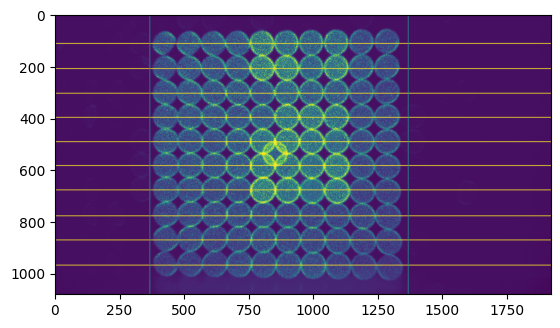

In [13]:
if RESET_ROIS:
    run_opt_multiROIs = {}
    run_opt_multiROIs['N_ROIs'] = N_ROI_ROWS

    frame_recording, times = capture_N_frames(cam, 10, *cam.get_im_size()[::-1]) # todo: should this 10 also be N_ROIs?

    def select_points_horiz(event, x, y, flags, param):
        global points, num_points
        
        # On left mouse button click
        if event == cv2.EVENT_LBUTTONDOWN:
            # Store the point
            points.append((x, y))
            
            # Draw a horizontal line across the row of the clicked point
            cv2.line(image, (0, y), (image.shape[1], y), 255, 2)
            cv2.imshow("Image", image)
            num_points += 1
            
            # If we have reached the desired number of points, stop
            if num_points >= param:
                cv2.setMouseCallback("Image", lambda *args : None)  # Disable further callbacks
                cv2.destroyAllWindows()
                
    def select_points_vert(event, x, y, flags, param):
        global points, num_points
        
        # On left mouse button click
        if event == cv2.EVENT_LBUTTONDOWN:
            # Store the point
            points.append((x, y))
            
            # Draw a horizontal line across the row of the clicked point
            cv2.line(image, (x, 0), (x,image.shape[0]), 255, 2)
            cv2.imshow("Image", image)
            num_points += 1
            
            # If we have reached the desired number of points, stop
            if num_points >= param:
                cv2.setMouseCallback("Image", lambda *args : None)  # Disable further callbacks
                cv2.destroyAllWindows()

    def get_points_from_image(image_np, N,select_points_fun):
        global image, points, num_points
        points = []  # Reset points list
        num_points = 0  # Reset point counter
        image = image_np.copy()  # Work on a copy of the image
        
        # Display the image and set the mouse callback function
        cv2.imshow("Image", image)
        cv2.setMouseCallback("Image", select_points_fun, param=N)
        
        # This ensures the window can update properly
        while True:
            # Wait for a key press
            key = cv2.waitKey(1) & 0xFF
            # If all points are selected or the user presses the 'q' key, exit loop
            if num_points >= N or key == ord('q'):
                break
        
        cv2.destroyAllWindows()
        
        return points

    image                = stretch_contrast(frame_recording[-1].copy())

    points = []
    num_points = 0
    selected_points      = get_points_from_image(image, run_opt_multiROIs['N_ROIs'],select_points_horiz)

    points = []
    num_points = 0
    selected_points_crop = get_points_from_image(image, 2, select_points_vert)

    print(selected_points)
    print(selected_points_crop)

    for x,y in selected_points:
        cv2.line(image, (0, y), (image.shape[1], y), 255, 2)
        
    for x,y in selected_points_crop:
        cv2.line(image, (x, 0), (x,image.shape[0]), 128, 2)

    plt.figure()
    plt.imshow(image)

## Compute ROIs

In [14]:
if RESET_ROIS:
    run_opt_multiROIs['ROI_height']         = ROI_ROW_HEIGHT
    run_opt_multiROIs['total_image_height'] = run_opt_multiROIs['N_ROIs'] * run_opt_multiROIs['ROI_height']

    # get ROI list
    ROI_list   = []
    ROI_values = []
    for x,y in selected_points:
        ROI_start = (y - run_opt_multiROIs['ROI_height']//2)
        ROI_start += ROI_start % 2
        ROI_end   = ROI_start + run_opt_multiROIs['ROI_height']
        ROI_list.append((ROI_start,ROI_end))
        ROI_vals  = np.arange(ROI_start,ROI_end,2)//2
        ROI_values.append(ROI_vals)

    ROI_values_single_list = np.asarray(ROI_values).flatten()
    print(f'ROIs list:\n{ROI_list}'); print('')
    print(f'values per ROI:\n{ROI_values}'); print('')
    print(f'all values list:\n{ROI_values_single_list}')
    print('Total image height = {}'.format(run_opt_multiROIs['total_image_height']))
    print('Max FPS = {} Hz'.format(int(1080/run_opt_multiROIs['total_image_height'] * 2247 * (1000/1024)**4)))

    OffsetX = int(np.round(selected_points_crop[0][0]/16)*16)
    Width   =  selected_points_crop[1][0] - OffsetX
    Width   =  int(np.round(Width/16)*16)

    run_opt_multiROIs['global_ROI'] = (OffsetX, 0,Width,run_opt_multiROIs['total_image_height'])
    print(run_opt_multiROIs['global_ROI'])
    
    # Save the row positions for later use (before they get overwritten)
    run_opt_multiROIs['selected_row_points'] = selected_points.copy()
    run_opt_multiROIs['ROI_list'] = ROI_list

ROIs list:
[(98, 128), (196, 226), (290, 320), (384, 414), (478, 508), (570, 600), (664, 694), (764, 794), (856, 886), (954, 984)]

values per ROI:
[array([49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]), array([ 98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
       111, 112]), array([145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159]), array([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204,
       205, 206]), array([239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251,
       252, 253]), array([285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297,
       298, 299]), array([332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344,
       345, 346]), array([382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394,
       395, 396]), array([428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440,
       441, 442]), array([477, 478, 479, 480, 481, 482, 483, 484, 485, 48

In [15]:
if RESET_ROIS:
    cam.set_rows(ROI_values_single_list)

## Preview the ROIs

In [16]:
# # DEBUG: interesting pop q option
# from threading import Thread, Lock
# from collections import deque

# class FramePreviewThread(Thread):
#     def __init__(self, cam, show_full_frame=True, queue_size=256):
#         super(FramePreviewThread, self).__init__()
#         self.cam = cam
#         self.running = True
#         self.show_full_frame = show_full_frame

#         self.w = cam.grabber.stream.get('Width')
#         self.h = cam.grabber.stream.get('Height')
#         self.h_roi = cam.get_global_roi()[-1]

#         if self.show_full_frame:
#             self.frame = np.zeros((self.h, self.w, 1), dtype=np.uint8)
#         else:
#             # last displayed frame (fallback if queue empty)
#             self.frame = np.zeros((self.h_roi, self.w, 1), dtype=np.uint8)

#         # queue of individual ROI frames for fast mode
#         self._q = deque(maxlen=queue_size)
#         self._lock = Lock()
#         self.frame_counter = 0

#     def __ptr_to_ndarray(self, ptr, w, size):
#         data = ct.cast(ptr, ct.POINTER(ct.c_ubyte * size)).contents
#         # reshape to (rows, w)
#         return np.frombuffer(data, count=size, dtype=np.uint8).reshape((-1, w))

#     def run(self):
#         while self.running:
#             with Buffer(self.cam.grabber, timeout=500) as buffer:
#                 buffer_ptr = buffer.get_info(BUFFER_INFO_BASE, INFO_DATATYPE_PTR)
#                 image_size = buffer.get_info(BUFFER_INFO_CUSTOM_PART_SIZE, INFO_DATATYPE_SIZET)
#                 delivered  = buffer.get_info(BUFFER_INFO_CUSTOM_NUM_DELIVERED_PARTS, INFO_DATATYPE_SIZET)

#                 if self.show_full_frame:
#                     proc = 0
#                     while proc < delivered:
#                         imagePtr = buffer_ptr + proc * image_size
#                         img = self.__ptr_to_ndarray(imagePtr, self.cam.w, image_size)
#                         # IMPORTANT: copy while buffer is valid
#                         self.frame[proc*self.h_roi:(proc+1)*self.h_roi, :, 0] = img.copy()
#                         proc += 1
#                         self.frame_counter = (self.frame_counter + 1) % 256
#                 else:
#                     # FAST MODE: enqueue each ROI as its own frame
#                     proc = 0
#                     while proc < delivered:
#                         imagePtr = buffer_ptr + proc * image_size
#                         img = self.__ptr_to_ndarray(imagePtr, self.cam.w, image_size).copy()
#                         # store as (h_roi, w, 1)
#                         with self._lock:
#                             if img.ndim == 2:
#                                 img = img[:, :, None]
#                             self._q.append(img)
#                         proc += 1
#                         self.frame_counter = (self.frame_counter + 1) % 256

#                     # Optional: keep `self.frame` in sync with last enqueued
#                     with self._lock:
#                         if self._q:
#                             self.frame = self._q[-1]

#     def read(self):
#         # Pop next frame if available (fast mode); else return last frame
#         if not self.show_full_frame:
#             with self._lock:
#                 if self._q:
#                     self.frame = self._q.popleft()
#         return self.frame, self.frame_counter

#     def stop(self):
#         self.running = False

In [17]:
class FramePreviewThread(Thread):
    def __init__(self, cam, show_full_frame=True):
        
        super(FramePreviewThread, self).__init__()
        self.cam = cam
        self.running = True

        self.w = cam.grabber.stream.get('Width')
        self.h = cam.grabber.stream.get('Height')
        self.h_roi = cam.get_global_roi()[-1]
        self.show_full_frame = show_full_frame
        
        if self.show_full_frame:
            self.frame = np.zeros((self.h,self.w,1),dtype='uint8')
        else:
            self.frame = np.zeros((self.h_roi,self.w,1),dtype='uint8')
        self.frame_counter = 0
        
    def __ptr_to_ndarray(self, ptr, w, size):
        data = ct.cast(ptr, ct.POINTER(ct.c_ubyte * size)).contents
        c = 1
        return np.frombuffer(data, count=size, dtype=np.uint8).reshape((-1,w))

    def run(self):        
        while self.running:
            with Buffer(self.cam.grabber, timeout=5000) as buffer:
                buffer_ptr = buffer.get_info(BUFFER_INFO_BASE, INFO_DATATYPE_PTR)
                image_size = buffer.get_info(BUFFER_INFO_CUSTOM_PART_SIZE, INFO_DATATYPE_SIZET)
                delivered  = buffer.get_info(BUFFER_INFO_CUSTOM_NUM_DELIVERED_PARTS, INFO_DATATYPE_SIZET)
                proc = 0
                while proc < delivered:
                    imagePtr = buffer_ptr + proc * image_size
                    img = self.__ptr_to_ndarray(imagePtr, self.cam.w, image_size)       
                    if self.show_full_frame:
                        self.frame[proc*self.h_roi:(proc+1)*self.h_roi,:,0] = img.copy()
                    else:
                        self.frame = img
                    proc = proc + 1                    
                    self.frame_counter =  (self.frame_counter + 1) % 256

    def read(self):
        return self.frame, self.frame_counter
    
    def stop(self):
        self.running = False

show_full_frame = 0

def preview_camera(cam, resize_factor = 1, gamma_val=2, is_strech_contrast=0,use_crop = None,
                   show_full_frame=True): 
    
    try:
        #cam.stop_acquisition()
        cam.grabber.start()
        #cam.start_acquisition()
        thread = FramePreviewThread(cam,show_full_frame=show_full_frame)
        thread.start()
        cv2.namedWindow("frame")  
        
        # Get the window handle for the OpenCV window
        hwnd = ctypes.windll.user32.FindWindowW(None, "frame")
        
        prev_time = time.time()
        fps = 0

        while(True):
            
            frame,thread_counter = thread.read()

            frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)            
            
            if use_crop is not None:
                frame = frame[:,use_crop[0]:use_crop[1]]
                
            if resize_factor!=1:
                frame = cv2.resize(frame,None,fx = resize_factor, fy = resize_factor)
                
            # Calculate FPS
            #curr_time = time.time()
            #time_diff = curr_time - prev_time
            #fps = 1 / (time_diff + 1e-12)
            #prev_time = curr_time
            
            # Add FPS to the frame

            if is_strech_contrast:
                frame_show = stretch_contrast(frame)
            else:
                frame_show = frame
            
            cv2.putText(frame,'cam',(30,30), FONT, 0.75,(255,255,255),2,cv2.LINE_AA)    
            
            #fps_text = f'FPS: {fps:.2f}'
            #cv2.putText(frame_show, fps_text, (30, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255, 255, 255), 2, cv2.LINE_AA)


            cv2.imshow("frame",frame_show)
            
            # Bring the window to the front
            ctypes.windll.user32.SetWindowPos(hwnd, HWND_TOPMOST, 0, 0, 0, 0, SWP_NOMOVE | SWP_NOSIZE)

            key = cv2.waitKeyEx(1) 
            if key==13:
                break
            elif key==32: #space
                pass
            if key==40: # "( key"
                gamma_val-= 0.1
            if key==41: # ") key"
                gamma_val+= 0.1
                
    except Exception:
        traceback.print_exc()
        print('Closing camera thread.') 

    # cleanup
    cv2.destroyAllWindows()
    thread.stop()
    thread.join()
    #cam.stop_acquisition()
    cam.grabber.stop()
    cam.grabber.flush_buffers()

To exit the preview, click enter

In [18]:
if RESET_ROIS:
    preview_camera(cam,resize_factor=1,gamma_val=2.5,use_crop = None,show_full_frame=show_full_frame,is_strech_contrast=1)

## Horizontally Crop the ROI Rows


For some reason, you have to preview the ROI (which we do above) before horozontally cropping it otherwise the crop will fail.

In [19]:
if RESET_ROIS:
    cam.set_global_roi_noy(*run_opt_multiROIs['global_ROI'])

    print(f'ROI = {cam.get_global_roi()}')
    print(f'frame rate  = {cam.get_frame_rate()} [FPS]')
    print(f'exposure  = {cam.get_exposure()} [us]')
    print(f'max frame rate = {cam.get_max_frame_rate()} [Hz]')

ROI = (368, 0, 992, 300)
frame rate  = 500 [FPS]
exposure  = 30 [us]
max frame rate = 7970 [Hz]


In [20]:
preview_camera(cam,resize_factor=1,gamma_val=2.5,use_crop = None,show_full_frame=show_full_frame,is_strech_contrast=1)

## Set ROI Columns

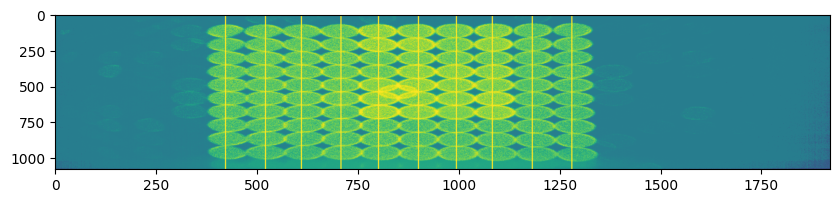

In [21]:
if RESET_ROIS:
    from utils.recover_core_lib import *

    run_opt_recovery['N_vert_ROIs']    = N_ROI_COLUMNS

    points = []
    num_points = 0

    raw_frame = frame_recording[N_ROI_COLUMNS-1].copy().astype(np.float32)

    # 2. Apply Log Transform: I_out = log(1 + I_in)
    image_log = np.log1p(raw_frame)

    # 3. Normalize the log image to 0-255 range for display (uint8)
    image = cv2.normalize(image_log, None, 0, 255, cv2.NORM_MINMAX)
    image = image.astype(np.uint8)

    min_height = 20 
    h, w = image.shape
    if h < min_height:
        repeat_factor = math.ceil(min_height / h)
        image = np.repeat(image, repeat_factor, axis=0)

    # Rename to avoid overwriting the row points
    selected_column_points = get_points_from_image(image, run_opt_recovery['N_vert_ROIs'])

    for x, y in selected_column_points:
        cv2.line(image, (x, 0), (x, image.shape[0]), 255, 2)

    plt.figure(figsize=(10, 2))
    plt.imshow(image, aspect='auto') 
    plt.show()

In [22]:
if RESET_ROIS:
    if 'run_opt_multiROIs' in run_opt:
        run_opt_multiROIs = run_opt['run_opt_multiROIs']
    else: # runs in manual mode
        print('running manually')
        # run_opt_multiROIs = {}
        run_opt_multiROIs['N_ROIs'] = N_ROI_ROWS
        run_opt_multiROIs['ROI_height'] = ROI_ROW_HEIGHT
        
    print(run_opt_multiROIs)

running manually
{'N_ROIs': 10, 'ROI_height': 30, 'total_image_height': 300, 'global_ROI': (368, 0, 992, 300), 'selected_row_points': [(425, 113), (804, 210), (798, 305), (802, 398), (805, 492), (802, 584), (800, 678), (806, 778), (807, 871), (812, 968)], 'ROI_list': [(98, 128), (196, 226), (290, 320), (384, 414), (478, 508), (570, 600), (664, 694), (764, 794), (856, 886), (954, 984)]}


## Final ROI Preview

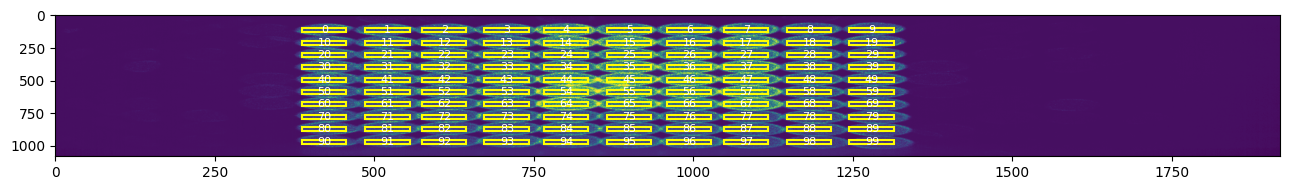

In [23]:
import matplotlib.patches as patches

run_opt_recovery['N_vert_ROI_width'] = ROI_COLUMN_WIDTH

# Get the saved row and column positions
selected_row_points = run_opt_multiROIs['selected_row_points']
# Use selected_column_points if available, otherwise fall back to selected_points
if 'selected_column_points' not in locals():
    selected_column_points = selected_points

ROIs = []
for row_idx in range(run_opt_multiROIs['N_ROIs']):
    for col_idx in range(run_opt_recovery['N_vert_ROIs']):
        x = selected_column_points[col_idx][0] - run_opt_recovery['N_vert_ROI_width'] // 2
        # Use the actual clicked y-position instead of row * height
        y = selected_row_points[row_idx][1] - run_opt_multiROIs['ROI_height'] // 2
        w = run_opt_recovery['N_vert_ROI_width']
        h = run_opt_multiROIs['ROI_height']
        ROIs.append((x, y, w, h))

# manual change
if 0:
    ROIs = ROIs[6:]
    ROIs.append((385 - run_opt_recovery['N_vert_ROI_width'] // 2, 0, w, h))

run_opt_multiROIs['ROIs'] = ROIs

# 1. Get the clean image (Do not draw cv2 rectangles on it)
frame_show = stretch_contrast(frame_recording[-1].copy())

# 2. Setup the plot
fig, ax = plt.subplots(figsize=(13, 2))
ax.imshow(frame_show, aspect='auto')

# 3. Add Vector Rectangles and Text on top
for i, (x, y, w, h) in enumerate(run_opt_multiROIs['ROIs']):
    # Create the rectangle patch
    # (x - 0.5, y - 0.5) aligns the border exactly around the pixels
    rect = patches.Rectangle((x - 0.5, y - 0.5), w, h, 
                             linewidth=1.5,      # Fixed screen width (remains thin)
                             edgecolor='yellow', # Color
                             facecolor='none')   # Transparent center
    
    # Add the rectangle to the plot
    ax.add_patch(rect)
    
    # Add the text label
    # Calculating center for the text position
    center_x = x + w / 2
    center_y = y + h / 2
    ax.text(center_x, center_y, str(i), 
            color='white', fontsize=8, 
            ha='center', va='center')

plt.tight_layout()
plt.show()

In [24]:
RESET_ROIS = False

## Set high frame rate for capturing

In [25]:
run_opt['cam_params']['camera_FPS'] = FPS
run_opt['cam_params']['exposure']   = EXPOSURE # how much light we let in
run_opt['cam_params']['gain']       = GAIN # amplify the elctrical signal caused by the photons

cam.set_frame_rate(run_opt['cam_params']['camera_FPS'])
cam.set_exposure(run_opt['cam_params']['exposure'])
cam.set_gain(run_opt['cam_params']['gain'])

print(f'ROI = {cam.get_global_roi()}')
print('Image height = {:} [px]'.format(cam.grabber.stream.get('Height')))
print(f'frame rate  = {cam.get_frame_rate()} [FPS]')
print(f'exposure  = {cam.get_exposure()} [us]')
print(f'max frame rate = {cam.get_max_frame_rate()} [Hz]')

if 1:
    run_opt['cam_params']['get_global_roi'] = cam.get_global_roi()
    run_opt['cam_params']['get_frame_rate'] = cam.get_frame_rate()
    run_opt['cam_params']['get_max_frame_rate'] = cam.get_max_frame_rate()
    run_opt['cam_params']['get_exposure'] = cam.get_exposure()

ROI = (368, 0, 992, 300)
Image height = 300 [px]
frame rate  = 2500 [FPS]
exposure  = 150 [us]
max frame rate = 7970 [Hz]


In [26]:
# makes it faster to capture/send frames
cam.set_buffer_part_count(BUFFER_PART_COUNT)

# 3. Setup Audio

In [27]:
# preview of the audio file
winsound.PlaySound(AUDIO_FILE, winsound.SND_FILENAME | winsound.SND_ASYNC)

# 4. Setup Overhead Camera

In [28]:
import sys
from pathlib import Path

# Add parent directory to path for utils imports
parent_dir = Path.cwd().parent
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))

from pyueye import ueye
from utils.ids_camera.pyueye_example_camera import Camera
from utils.image_processing import adjustGamma

In [29]:
def setup_camera(exposure_ms=3.0, frame_rate=30, pixel_clock=86, gain=0):
    """
    Initialize and configure IDS camera with specified parameters.
    
    Args:
        exposure_ms: Exposure time in milliseconds
        frame_rate: Target frame rate in FPS
        pixel_clock: Pixel clock speed
        gain: Camera gain (0-100)
    
    Returns:
        overhead_cam: Configured Camera object
        img_size: Tuple of (width, height)
    """

    # Check if cam exists in the local namespace and close it
    # Simply calling `del cam` will fail because Python's garbage collector doesn't necessarily close the hardware driver connection immediately, leaving the camera locked.
    global overhead_cam
    if 'overhead_cam' in locals() or 'overhead_cam' in globals():
        try:
            overhead_cam.exit() 
            print("Closed existing camera connection.")
        except:
            pass

    # Initialize camera
    overhead_cam = Camera(device_id=0)
    overhead_cam.init()
    overhead_cam.set_colormode(ueye.IS_CM_SENSOR_RAW8)
    overhead_cam.alloc(buffer_count=40)
    
    # Set camera parameters (set_frame_rate returns the actual frame rate)
    overhead_cam.set_pixel_clock(pixel_clock)
    overhead_cam.set_exposure(exposure_ms)
    overhead_cam.set_gain(gain)
    actual_fps = overhead_cam.set_frame_rate(frame_rate)
    
    # Get actual settings and image size
    actual_exposure = overhead_cam.get_exposure()
    actual_pixel_clock = overhead_cam.get_pixel_clock()
    actual_gain = overhead_cam.get_gain()
    img_w = overhead_cam.get_aoi().width
    img_h = overhead_cam.get_aoi().height
    
    print('===== Camera Setup =====')
    print(f'Image size: {img_w}x{img_h}')
    print(f'Exposure: {actual_exposure:.3f} ms')
    print(f'Frame rate: {actual_fps:.3f} FPS')
    print(f'Pixel clock: {actual_pixel_clock} MHz')
    print(f'Gain: {actual_gain}')
    
    return overhead_cam, (img_w, img_h)

In [30]:
def preview_image(overhead_cam, resize_factor=0.75, gamma=1.0):
    """
    Display live camera preview. Press Enter to exit.
    
    Args:
        overhead_cam: Camera object
        resize_factor: Scale factor for display (0-1)
        gamma: Gamma correction value
    """
    # Start video capture
    overhead_cam.disable_external_trigger()
    overhead_cam.capture_video()
    
    cv2.namedWindow("IDS Camera Preview")
    
    try:
        while True:
            # Capture raw frame
            raw_frame, _ = overhead_cam.read_frame()
            
            # Convert Bayer to BGR FIRST (before rotation to preserve Bayer pattern)
            frame = cv2.cvtColor(raw_frame.astype('uint8'), cv2.COLOR_BAYER_BG2BGR)
            
            # Rotate 180 degrees to fix camera orientation
            frame = cv2.rotate(frame, cv2.ROTATE_180)
            
            # Apply gamma correction (adjustGamma is imported at top)
            if gamma != 1.0:
                frame = adjustGamma(frame, gamma=gamma)
            
            # Resize for display
            if resize_factor != 1:
                frame = cv2.resize(frame, None, fx=resize_factor, fy=resize_factor)
            
            # Add info text
            cv2.putText(frame, 'Press Enter to exit', (10, 30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
            
            cv2.imshow("IDS Camera Preview", frame)
            
            # Exit on Enter key
            if cv2.waitKey(1) == 13:
                break
                
    finally:
        cv2.destroyAllWindows()
        overhead_cam.stop_video()

In [31]:
def capture_image(overhead_cam):
    # Start video capture mode
    overhead_cam.disable_external_trigger()
    overhead_cam.capture_video()
    
    # Capture single frame
    raw_frame, timestamp = overhead_cam.read_frame()
    
    # Stop capture
    overhead_cam.stop_video()
    
    # Convert to color FIRST (before rotation to preserve Bayer pattern)
    color_image = cv2.cvtColor(raw_frame.astype('uint8'), cv2.COLOR_BAYER_BG2BGR)
    
    # Rotate 180 degrees to fix camera orientation
    color_image = cv2.rotate(color_image, cv2.ROTATE_180)
    raw_frame = cv2.rotate(raw_frame, cv2.ROTATE_180)
    
    print(f'Image captured at {timestamp}')
    print(f'Shape: {color_image.shape}')
    
    return color_image, raw_frame

In [32]:
def save_image(image, BASE_DIR, filename=None):
    os.makedirs(BASE_DIR, exist_ok=True)
    
    if filename is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f'box_image_{timestamp}.png'
    
    filepath = os.path.join(BASE_DIR, filename)
    cv2.imwrite(filepath, image)
    print(f'Image saved to: {filepath}')    
    return filepath

In [120]:
overhead_cam, img_size = setup_camera(exposure_ms=EXPOSURE_MS, frame_rate=FRAME_RATE, pixel_clock=PIXEL_CLOCK, gain=CAMERA_GAIN)
# set to true to preview camera feed and adjust settings/frame
if PREVIEW_OVERHEAD_BOX_IMAGE:
    preview_image(overhead_cam, resize_factor=RESIZE_FACTOR, gamma=GAMMA)

Closed existing camera connection.
===== Camera Setup =====
Image size: 2056x1542
Exposure: 30.002 ms
Frame rate: 29.999 FPS
Pixel clock: 237 MHz
Gain: 40


# 5. Run the Experiment

In [196]:
EXPERIMENT_NAME = 'circle-position4-01'

## Snap a Pic

Image captured at [ 17  17  24 274]
Shape: (1542, 2056, 3)


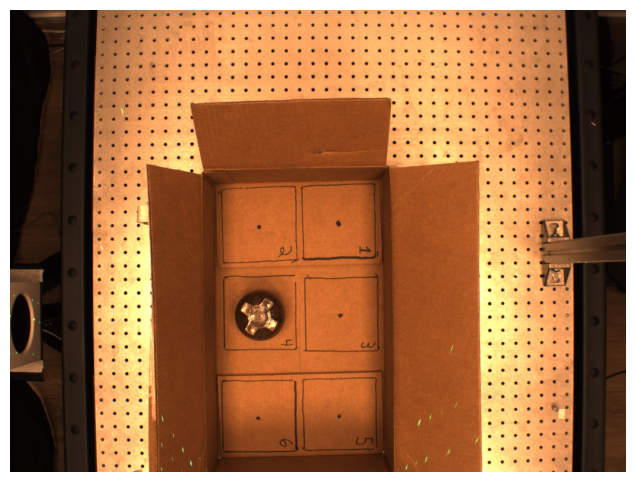

In [197]:
image, raw_image = capture_image(overhead_cam)

# Display the captured image
plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

## Record Laser Vibrations

captured 15000 frames


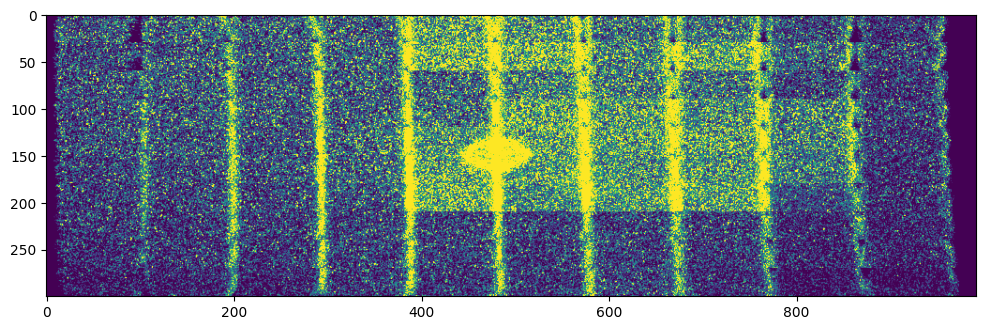

In [199]:
IS_PLAY_SOUND = True
N_frames      = int(N_CAPTURE_SECONDS * run_opt['cam_params']['camera_FPS'])

if IS_PLAY_SOUND:
    winsound.PlaySound(AUDIO_FILE, winsound.SND_FILENAME | winsound.SND_ASYNC)
frame_recording, times = capture_N_frames(cam, N_frames, *cam.get_im_size()[::-1])

print(f'captured {N_frames} frames')
plt.figure(figsize=(12,6))
MINMAX = (np.percentile(frame_recording[-100:],10),
          np.percentile(frame_recording[-100:],90))

plt.imshow(frame_recording[10],vmin=MINMAX[0],vmax=MINMAX[1])

## Show captured video

Click `*` to scroll throuigh the video and `enter` to exit.

In [200]:
PREVIEW_VIBRATION_VIDEO = True

In [201]:
if PREVIEW_VIBRATION_VIDEO:
    from utils.opencv_video_utils import videoPlayer

    class videoPlayerv2(videoPlayer):
        def additional_loop_control(self,key):
            if key==42:
                self.data_counter=(self.data_counter+100) % self.N_frames 
            if key==47:
                self.data_counter=(self.data_counter-100) % self.N_frames 

    def get_frameshow(data_counter):
        frame      = frame_recording[data_counter].copy()
        frame_show = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
        frame_show = stretch_contrast(frame_show)
        return frame_show

    show_frame_number = 1

    N_frames           = frame_recording.shape[0]
    resize_factor      = 2
    get_frame_func     = get_frameshow

    video_player       = videoPlayerv2(get_frame_func,N_frames,resize_factor=resize_factor)
    video_player.play_video(move_window=0,show_frame_number=show_frame_number)

## Save Experiment

In [202]:
import json

In [203]:
experiment_config = {
    "ROI_ROW_HEIGHT": ROI_ROW_HEIGHT,
    "N_ROI_ROWS": N_ROI_ROWS,
    "N_ROI_COLUMNS": N_ROI_COLUMNS,
    "ROI_COLUMN_WIDTH": ROI_COLUMN_WIDTH,
    "CALIBRATION_FPS": CALIBRATION_FPS,
    "CALIBRATION_EXPOSURE": CALIBRATION_EXPOSURE,
    "CALIBRATION_GAIN": CALIBRATION_GAIN,
    "FPS": FPS,
    "EXPOSURE": EXPOSURE,
    "GAIN": GAIN,
    "BUFFER_PART_COUNT": BUFFER_PART_COUNT,
    "EXPOSURE_MS": EXPOSURE_MS,
    "FRAME_RATE": FRAME_RATE,
    "PIXEL_CLOCK": PIXEL_CLOCK,
    "CAMERA_GAIN": CAMERA_GAIN,
    "RESIZE_FACTOR": RESIZE_FACTOR,
    "GAMMA": GAMMA,
    "AUDIO_FILE": AUDIO_FILE,
    "N_CAPTURE_SECONDS": N_CAPTURE_SECONDS
}

Takes ~1 minute to save

In [204]:
current_time = datetime.now().strftime("--%d-%m-%H-%M-%S")
OUT_DIR = os.path.join(BASE_DIR, EXPERIMENT_NAME + current_time)
os.makedirs(OUT_DIR, exist_ok=True)

# save overhead box image
box_overhead_image = filepath = os.path.join(OUT_DIR, 'box_overhead_image.png')
cv2.imwrite(filepath, image)
print(f'Saved box overhead image to: {filepath}')

# Save frame recording
frame_recording_filepath = os.path.join(OUT_DIR, f'frame-recording.npy')
np.save(frame_recording_filepath, frame_recording)
print(f'Saved {frame_recording.shape[0]} data samples to: {frame_recording_filepath}')

# Save metadata
metadata_filepath = os.path.join(OUT_DIR, f'metadata.npz')
run_opt['run_opt_multiROIs'] = run_opt_multiROIs
np.savez(metadata_filepath, experiment_name=EXPERIMENT_NAME, run_opt=run_opt)
print(f'Saved metadata to: {metadata_filepath}')

# Save config
params_filepath = os.path.join(OUT_DIR, f'experiment_config.json')
with open(params_filepath, 'w') as f:
    json.dump(experiment_config, f, indent=4)
print(f'Saved experiment config to: {params_filepath}')

print('Experiment saved successfully!')

Saved box overhead image to: Z:\DATA\Eitan\experiment_02\circle-position4-01--07-01-17-17-57\box_overhead_image.png
Saved 15000 data samples to: Z:\DATA\Eitan\experiment_02\circle-position4-01--07-01-17-17-57\frame-recording.npy
Saved metadata to: Z:\DATA\Eitan\experiment_02\circle-position4-01--07-01-17-17-57\metadata.npz
Saved experiment config to: Z:\DATA\Eitan\experiment_02\circle-position4-01--07-01-17-17-57\experiment_config.json
Experiment saved successfully!
